<h1 align=center>Robi Hackathon 2.0 - Team Instinct</h1>

# Team Members
---

<p><b>Nuren Shams (Team Lead)</b><br>Email: Nuren.Shams@NorthSouth.edu</p>

<p><b>Arnab Saha</b><br>Email: ArnabSaha370Z@Gmail.com</p>

<p><b>S. M. Al Faruqui</b><br>Email: S.M.Faruqui@NorthSouth.edu</p>

<p><b>Tahsinul Islam</b><br>Email: Tahsinul.Islam@NorthSouth.edu</p>

<p><b>Mohammad Zariff Ahsham Ali</b><br>Email: Zariff.Zaff.15@Gmail.com</p>

In [1]:
import folium
import geojson
from keplergl import KeplerGl
from math import radians, cos, sin, asin, sqrt
import numpy as np
import os
import pandas as pd
import re
from tqdm.notebook import tqdm, trange
import seaborn as sns 
import matplotlib.pyplot as plt
import geohash_hilbert as ghh

PARAM_ROOT_DATA_DIR = "./data/"
PARAM_AGENT_TABLE_DIR = "./data/agent.csv"
PARAM_PRODUCT_TABLE_DIR = "./data/product.csv"
PARAM_TRANSACTION_SHARDS_DIR = "./data/transactions/"
PARAM_ENCODED_DATA_DIR = "./encoded_data/"

# Source: https://en.banglapedia.org/index.php/Bangladesh
PARAM_BGD_LAT_MAX = 26.64
PARAM_BGD_LAT_MIN = 20.56
PARAM_BGD_LON_MAX = 92.69
PARAM_BGD_LON_MIN = 88.01

# Data Engineering
---
Because the Agent, Customer and Product Identifiers are string fields, they can be compressed to reduce the memory requirements of the dataset. This is achieved through loading all the datasets (and their shards) into memory one by one to compile a list of unique artifacts. Afterwards, the exhaustive collection of artifacts are encoded into integer representations through a deterministic ordinal serialization process<sup>[1]</sup>. This process results in a hashmap that can encode the true-identifiers and an inverse hashmap that can decode the custom encoding scheme back into the true-identifiers.

<sup>[1]</sup>There are **109,820** distinct Agents (requires a 32-bit unsigned integer because it can cover a range between 0 to 4,294,967,295), **101,030** distinct Customers (also requires a 32-bit unsigned integer) and **2,127** distinct Products (requires a 16-bit unsigned integer because it can cover a range between 0 to 65,535).

In [ ]:
print("Loading the Agent Table into memory.")
agent_df = pd.read_csv(PARAM_AGENT_TABLE_DIR)
print("Loading the Product Table into memory.")
product_df = pd.read_csv(PARAM_PRODUCT_TABLE_DIR)

# Scan for the unique identifiers
agent_ids = agent_df["agent"].tolist()
customer_ids = list()
product_ids = product_df["product"].tolist()
transaction_dfs = list()
print("Loading the Transaction Table Shards into memory.")
for root, dirs, files in os.walk(PARAM_TRANSACTION_SHARDS_DIR):
    for file in tqdm(files):
        if not bool(re.fullmatch("^part[0-9\-a-f]*.csv$", file)):
            continue
        else:
            transaction_dfs.append(pd.read_csv(PARAM_TRANSACTION_SHARDS_DIR+file))
            agent_ids = list(set(agent_ids+transaction_dfs[-1]["agent"].tolist()))
            customer_ids = list(set(customer_ids+transaction_dfs[-1]["customer"].tolist()))
            product_ids = list(set(product_ids+transaction_dfs[-1]["product"].tolist()))
            pass
        pass
    pass
print("Generated Identifier Sets.")

# Sort by ordinal
print("Sorting Identifiers by Ordinal.")
agent_ids.sort(reverse=False)
customer_ids.sort(reverse=False)
product_ids.sort(reverse=False)

# Build the encoder-decoder hashmaps
print("Generating encoder/decoder hashmaps.")
agent_id_encoder_map = dict()
agent_id_decoder_map = dict()
customer_id_encoder_map = dict()
customer_id_decoder_map = dict()
product_id_encoder_map = dict()
product_id_decoder_map = dict()

for index, agent_id in enumerate(tqdm(agent_ids)):
    agent_id_encoder_map[agent_id] = index
    agent_id_decoder_map[index] = agent_id
    pass

for index, customer_id in enumerate(tqdm(customer_ids)):
    customer_id_encoder_map[customer_id] = index
    customer_id_decoder_map[index] = customer_id
    pass

for index, product_id in enumerate(tqdm(product_ids)):
    product_id_encoder_map[product_id] = index
    product_id_decoder_map[index] = product_id
    pass

# Create the encoded dataset directory structure
print("Preparing the directory structure for caching the encoded datasets.")
try:
    os.makedirs(PARAM_ENCODED_DATA_DIR+"transactions/")
    pass
except OSError:
    pass

# Generate the compressed agent.csv dataset
print("Generating the encoded Agent Table.")
agent_df["agent"] = agent_df["agent"].apply(lambda arg : agent_id_encoder_map[arg])
agent_df.to_csv(PARAM_ENCODED_DATA_DIR+"agent.csv", index=False)

# Generate the compressed product.csv dataset
print("Generating the encoded Product Table.")
product_df["product"] = product_df["product"].apply(lambda arg : product_id_encoder_map[arg])
product_df.to_csv(PARAM_ENCODED_DATA_DIR+"product.csv", index=False)

# Generate the compressed transaction shards
print("Generating the encoded Transaction Table Shards.")
for iterator in trange(len(transaction_dfs)):
    transaction_dfs[iterator]["agent"] = transaction_dfs[iterator]["agent"].apply(lambda arg : agent_id_encoder_map[arg])
    transaction_dfs[iterator]["customer"] = transaction_dfs[iterator]["customer"].apply(lambda arg : customer_id_encoder_map[arg])
    transaction_dfs[iterator]["product"] = transaction_dfs[iterator]["product"].apply(lambda arg : product_id_encoder_map[arg])
    transaction_dfs[iterator].to_csv(PARAM_ENCODED_DATA_DIR+"transactions/"+file, index=False)
    pass

# Merge all transaction shards
print("Generating the merged Transaction Table.")
transaction_df = pd.concat(transaction_dfs)
transaction_df.to_csv(PARAM_ENCODED_DATA_DIR+"transaction.csv", index=False)

# Flush the memory from any data engineering residues
print("Flushing the memory from any Data Engineering residues.")
del agent_df
del product_df
del transaction_df

del agent_ids
del customer_ids
del product_ids

del transaction_dfs

## Entity Junction/Association Tables
Generate the entity association tables to decode the (memory efficient) custom identifier scheme back to the original (Robi provided) identifier scheme.

In [ ]:
df = pd.DataFrame()
df["agent"] = list(agent_id_encoder_map.keys())
df["agent_id"] = list(agent_id_encoder_map.values())
df.to_csv(PARAM_ENCODED_DATA_DIR+"agent_association.csv", index=False)

df = pd.DataFrame()
df["customer"] = list(customer_id_encoder_map.keys())
df["customer_id"] = list(customer_id_encoder_map.values())
df.to_csv(PARAM_ENCODED_DATA_DIR+"customer_association.csv", index=False)

df = pd.DataFrame()
df["product"] = list(product_id_encoder_map.keys())
df["product_id"] = list(product_id_encoder_map.values())
df.to_csv(PARAM_ENCODED_DATA_DIR+"product_association.csv", index=False)

del df

## Prepare the GeoJSON Table
The GeoJSONs are downloaded in a merged format that's unsuitable for hosting as a table and performing tabular operations on. This section splits the data into a tabular form that's ready to be joined with other tables through geo-operations.

In [ ]:
admin_levels = list()
shape_names = list()
geo_jsons = list()

for iterator in tqdm([0,1,2,3,4]):
    with open(PARAM_ROOT_DATA_DIR+F"geojsons/geoBoundaries-BGD-ADM{iterator}_simplified.geojson") as file_stream:
        geojson_obj = geojson.load(file_stream)
        pass
    for feature in tqdm(geojson_obj["features"]):
        admin_levels.append(feature["properties"]["Level"])
        shape_names.append(feature["properties"]["shapeName"])
        geo_jsons.append(feature["geometry"])
        pass
    pass

df = pd.DataFrame({
    "adm_level": admin_levels,
    "adm_name": shape_names,
    "geo_json": geo_jsons
})

df.to_csv("./data/geo_json.csv", index=False)

# Data Loader Function Definitions
---
These functions are designed based on the Data Engineering EDA to load the compressed datasets into memory in an efficient scheme.

In [2]:
def load_agent_table(path):
    return pd.read_csv(path).astype({
        "agent": np.uint32,
        "lat": np.float64,
        "lon": np.float64,
        "ts": str
    })

def load_product_table(path):
    return pd.read_csv(path).astype({
        "price": np.float64,
        "dt": str,
        "product": np.uint16
    })

def load_transaction_table(path):
    return pd.read_csv(path).astype({
        "agent": np.uint32,
        "customer": np.uint32,
        "product": np.uint16,
        "dt": str,
        "ts": str
    })

# Pre-Processing
---
- Drop Agents that have NaN lat/lon
- Drop the Timestamp column because there are only two distinct values with unchanging lat/lon. Hence they don't add any extra information.
- Drop duplicate Agent lat/lon rows

In [8]:
agent_df = load_agent_table(PARAM_ENCODED_DATA_DIR+"agent.csv")
product_df = load_product_table(PARAM_ENCODED_DATA_DIR+"product.csv")
transaction_df = load_transaction_table(PARAM_ENCODED_DATA_DIR+"transaction.csv")

agent_df = agent_df.dropna().reset_index(drop=True)
agent_df.drop(columns=['ts'], axis=0, inplace=True)
agent_df.drop_duplicates(keep='last', inplace=True)
agent_df = agent_df.reset_index(drop=True)

# Load the Encoder/Decoder Hashmaps

In [5]:
df = pd.read_csv(PARAM_ENCODED_DATA_DIR+"agent_association.csv")
agent_id_encoder_map = dict()
agent_id_decoder_map = dict()
for key, value in zip(df["agent_id"].tolist(), df["agent"].tolist()):
    agent_id_encoder_map[value] = key
    agent_id_decoder_map[key] = value
    pass

df = pd.read_csv(PARAM_ENCODED_DATA_DIR+"customer_association.csv")
customer_id_encoder_map = dict()
customer_id_decoder_map = dict()
for key, value in zip(df["customer_id"].tolist(), df["customer"].tolist()):
    customer_id_encoder_map[value] = key
    customer_id_decoder_map[key] = value
    pass

df = pd.read_csv(PARAM_ENCODED_DATA_DIR+"product_association.csv")
product_id_encoder_map = dict()
product_id_decoder_map = dict()
for key, value in zip(df["product_id"].tolist(), df["product"].tolist()):
    product_id_encoder_map[value] = key
    product_id_decoder_map[key] = value
    pass

# Join DataFrames

In [ ]:
mega_df = transaction_df.merge(agent_df, on=['agent'], how='inner')
mega_df = mega_df.merge(product_df, on=['product'], how='inner')
mega_df.to_csv(PARAM_ENCODED_DATA_DIR+"/mega_df.csv", index=False)

del transaction_df
del mega_df

In [6]:
mega_df = pd.read_csv(PARAM_ENCODED_DATA_DIR+"/mega_df.csv")

#  Retail Points in Bangladesh with Geographic Visualization

### Dropping all the agents with latitudes & longitudes outside of Bangladesh

In [9]:
agent_df = agent_df[(agent_df['lat'] >= PARAM_BGD_LAT_MIN) & (agent_df['lat'] <= PARAM_BGD_LAT_MAX)]
agent_df = agent_df[(agent_df['lon'] >= PARAM_BGD_LON_MIN) & (agent_df['lon'] <= PARAM_BGD_LON_MAX)]

### KeplerGL config json

In [10]:
config_json = {'version': 'v1',
 'config': {'visState': {'filters': [],
   'layers': [{'id': 'szb8s',
     'type': 'geojson',
     'config': {'dataId': 'District',
      'label': 'District',
      'color': [38, 71, 172],
      'highlightColor': [252, 242, 26, 255],
      'columns': {'geojson': '_geojson'},
      'isVisible': True,
      'visConfig': {'opacity': 0.01,
       'strokeOpacity': 0.8,
       'thickness': 0.5,
       'strokeColor': [166, 165, 165],
       'colorRange': {'name': 'Global Warming',
        'type': 'sequential',
        'category': 'Uber',
        'colors': ['#5A1846',
         '#900C3F',
         '#C70039',
         '#E3611C',
         '#F1920E',
         '#FFC300']},
       'strokeColorRange': {'name': 'Global Warming',
        'type': 'sequential',
        'category': 'Uber',
        'colors': ['#5A1846',
         '#900C3F',
         '#C70039',
         '#E3611C',
         '#F1920E',
         '#FFC300']},
       'radius': 10,
       'sizeRange': [0, 10],
       'radiusRange': [0, 50],
       'heightRange': [0, 500],
       'elevationScale': 5,
       'enableElevationZoomFactor': True,
       'stroked': True,
       'filled': True,
       'enable3d': False,
       'wireframe': False},
      'hidden': False,
      'textLabel': [{'field': None,
        'color': [255, 255, 255],
        'size': 18,
        'offset': [0, 0],
        'anchor': 'start',
        'alignment': 'center'}]},
     'visualChannels': {'colorField': None,
      'colorScale': 'quantile',
      'strokeColorField': None,
      'strokeColorScale': 'quantile',
      'sizeField': None,
      'sizeScale': 'linear',
      'heightField': None,
      'heightScale': 'linear',
      'radiusField': None,
      'radiusScale': 'linear'}},
    {'id': 'seykzfn',
     'type': 'point',
     'config': {'dataId': 'Agent',
      'label': 'Agent',
      'color': [32, 103, 172],
      'highlightColor': [252, 242, 26, 255],
      'columns': {'lat': 'lat', 'lng': 'lon', 'altitude': None},
      'isVisible': True,
      'visConfig': {'radius': 5,
       'fixedRadius': False,
       'opacity': 0.8,
       'outline': False,
       'thickness': 2,
       'strokeColor': None,
       'colorRange': {'name': 'Global Warming',
        'type': 'sequential',
        'category': 'Uber',
        'colors': ['#5A1846',
         '#900C3F',
         '#C70039',
         '#E3611C',
         '#F1920E',
         '#FFC300']},
       'strokeColorRange': {'name': 'Global Warming',
        'type': 'sequential',
        'category': 'Uber',
        'colors': ['#5A1846',
         '#900C3F',
         '#C70039',
         '#E3611C',
         '#F1920E',
         '#FFC300']},
       'radiusRange': [0, 50],
       'filled': True},
      'hidden': False,
      'textLabel': [{'field': None,
        'color': [255, 255, 255],
        'size': 18,
        'offset': [0, 0],
        'anchor': 'start',
        'alignment': 'center'}]},
     'visualChannels': {'colorField': None,
      'colorScale': 'quantile',
      'strokeColorField': None,
      'strokeColorScale': 'quantile',
      'sizeField': None,
      'sizeScale': 'linear'}}],
   'interactionConfig': {'tooltip': {'fieldsToShow': {'Agent': [{'name': 'agent',
        'format': None}],
      'District': [{'name': 'shapeName', 'format': None}]},
     'compareMode': False,
     'compareType': 'absolute',
     'enabled': True},
    'brush': {'size': 0.5, 'enabled': False},
    'geocoder': {'enabled': False},
    'coordinate': {'enabled': False}},
   'layerBlending': 'normal',
   'splitMaps': [],
   'animationConfig': {'currentTime': None, 'speed': 1}},
  'mapState': {'bearing': 0,
   'dragRotate': False,
   'latitude': 23.61256117899912,
   'longitude': 90.34446743050015,
   'pitch': 0,
   'zoom': 6,
   'isSplit': False},
  'mapStyle': {'styleType': 'dark',
   'topLayerGroups': {},
   'visibleLayerGroups': {'label': True,
    'road': True,
    'border': False,
    'building': True,
    'water': True,
    'land': True,
    '3d building': False},
   'threeDBuildingColor': [9.665468314072013,
    17.18305478057247,
    31.1442867897876],
   'mapStyles': {}}}}

In [11]:
# Download the GeoJson file for Bangladesh Administrative Level 2 (District Level)

!wget 'https://github.com/wmgeolab/geoBoundaries/raw/24a4f5fc8428fd703be41ef85f75cddbe8c099f8/releaseData/gbOpen/BGD/ADM2/geoBoundaries-BGD-ADM2_simplified.geojson'

--2022-06-25 06:08:21--  https://github.com/wmgeolab/geoBoundaries/raw/24a4f5fc8428fd703be41ef85f75cddbe8c099f8/releaseData/gbOpen/BGD/ADM2/geoBoundaries-BGD-ADM2_simplified.geojson
Resolving github.com (github.com)... 20.205.243.166
Connecting to github.com (github.com)|20.205.243.166|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/wmgeolab/geoBoundaries/24a4f5fc8428fd703be41ef85f75cddbe8c099f8/releaseData/gbOpen/BGD/ADM2/geoBoundaries-BGD-ADM2_simplified.geojson [following]
--2022-06-25 06:08:22--  https://raw.githubusercontent.com/wmgeolab/geoBoundaries/24a4f5fc8428fd703be41ef85f75cddbe8c099f8/releaseData/gbOpen/BGD/ADM2/geoBoundaries-BGD-ADM2_simplified.geojson
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response

# Q1: Where are the retail points in Bangladesh as per latest valid data with a geographic visualization of the retail distribution network?

In [12]:
bd_map = KeplerGl(height=720)

bd_map.add_data(data=agent_df, name='Agent')

with open('geoBoundaries-BGD-ADM2_simplified.geojson', 'r') as f:
    district_geojson = f.read()
    
bd_map.add_data(data=district_geojson, name='District')

bd_map.config = config_json

User Guide: https://docs.kepler.gl/docs/keplergl-jupyter


## Map Visualization

The map below shows us the retail points plotted against the map of Bangladesh. We have also provided a geojson which shows the districts for better clarity. The point densities/colours/etc. can be dynamically changed by playing with the options to the left. We can also change the point type to show a heatmap or grid if we want a different kind of visualization

In [13]:
bd_map

KeplerGl(config={'version': 'v1', 'config': {'visState': {'filters': [], 'layers': [{'id': 'szb8s', 'type': 'g…

In [14]:
bd_map.save_to_html(file_name='bd_retail_points_2.html',read_only=False)

Map saved to bd_retail_points_2.html!


# Q2: Among highest selling top 100 retail, how many retail points have no other retail point nearby within 500 meter? What should be your recommendation for such retail points? Show examples of such retail on map to explain your recommendation, if you find any.


In [15]:
def haversine(lat1, lon1, lat2, lon2):
    """
    Calculate the great circle distance between two points 
    on the earth (specified in decimal degrees)
    """
    # convert decimal degrees to radians 
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])

    # haversine formula 
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a)) 
    r = 6371 # Radius of earth in kilometers. Use 3956 for miles
    return c * r * 1000

In [16]:
def top_selling_retailers(df, criteria='GMV'):
    
    if criteria=='GMV':
        agent_ranking = df.groupby(['agent']).sum()
    else:
        pass
        
    agent_ranking['agent'] = list(agent_ranking.index)
    agent_ranking = agent_ranking.reset_index(drop=True)
    
    if criteria=='GMV':
        agent_ranking = agent_ranking[['agent', 'price']]
        agent_ranking = agent_ranking.sort_values(by='price', ascending=False, axis=0).reset_index(drop=True)
        agent_ranking['ranking'] = [i+1 for i in range(len(agent_ranking))]
        
    else:
        pass
    
    return agent_ranking

### Merges the agent dataframe with their respective ranking & sales

In [17]:
agent_ranks = top_selling_retailers(mega_df)

agent_w_ranking = agent_df.merge(agent_ranks, on='agent', how='left')

agent_w_ranking

agent        lat        lon    price  ranking
0      80116  23.381238  89.989507   1403.0  81426.0
1      37563  24.924592  91.816217   1059.0  82133.0
2      97045  25.412105  89.343297      8.0  84558.0
3      92865  24.234658  88.813478    781.0  82792.0
4      11270  24.945879  89.301050    261.0  83889.0
...      ...        ...        ...      ...      ...
89605  15289  21.971249  90.430931    549.0  83265.0
89606  78316  23.389749  89.681231      NaN      NaN
89607  94276  23.873009  90.408819  66332.0  21321.0
89608  89929  24.765966  90.159301  22368.0  48836.0
89609  38997  24.631264  91.682902   2567.0  78948.0

[89610 rows x 5 columns]

### Finds the retailers within 500 meters radius of the top 100 retailers

In [18]:
def win_500m(df, ranking=100, output_map=False):
    
    top100 = df[(df['ranking']>0) & (df['ranking']<=ranking)].reset_index(drop=True)
    within_500m_list = []
    count = []
    
    if output_map:
        m = folium.Map([23.8103, 90.4125], zoom_start=13, control_scale=True)
    
    for i in tqdm(range(len(top100))):
        
        within_500m = {'agents':[], 'lats':[], 'lons':[]}
        
        main_lat = list(top100['lat'])[i]
        main_lon = list(top100['lon'])[i]
        
        if output_map:
            folium.Marker([main_lat, main_lon]).add_to(m)
            folium.Circle([main_lat, main_lon], radius=500, color='blue').add_to(m)
            
        
        lats = list(df['lat'])
        lons = list(df['lon'])
        agents = list(df['agent'])
        
        for j in range(len(df)):
            
            lat = lats[j]
            lon = lons[j]
            
            if main_lat!=lat and main_lon!=lon:
            
                hav_dist = haversine(main_lat, main_lon, lat, lon)

                if hav_dist<=500:
                    within_500m['agents'].append(agents[j])
                    within_500m['lats'].append(lat)
                    within_500m['lons'].append(lon)

                    if output_map:
                        folium.Circle([lat, lon], radius=10, tooltip= agents[j], color='blue').add_to(m)
            
        within_500m_list.append(within_500m)
        count.append(len(within_500m['agents']))
        
    top100['within_500m'] = within_500m_list
    top100['count'] = count
    
    if output_map:
        display(m)
    
    return top100

### Maps the top 100 retailers and tells how many retail points have no other retail point nearby within 500 meters

In [19]:
top100 = win_500m(agent_w_ranking, ranking=100, output_map=True)

print(f"{len(top100[top100['count']==0])} Retail points have no other retail point nearby within 500 meters")

  0%|          | 0/100 [00:00<?, ?it/s]

8 Retail points have no other retail point nearby within 500 meters


# Q3: How many geo-blocks (geohash of approx 1.2km x 0.6km) are there with retail?
---
To begin with, we removed the retails which existed outside the boundary of bangladesh.
We took the maximum coordinate boundary of Bangladesh from wikipedia and filtered out all the ones which existed outside this boundary.
We then proceeded to convert the lat/lon of each retail point to a geohash map and counted the distinct number of geohashes.There were 54099 geo-blocks with 89610 retail.

## WARNING: RUNNING THE CELL WILL MAKE THE NOTEBOOK VERY HEAVY
## ATTACHING A PART OF THE OUTPUT INSTEAD.

In [20]:
agent_df['geo_hash']= [ghh.encode(lon, lat, precision=6) for lat, lon in zip(list(agent_df['lat']), list(agent_df['lon']))]
print(f"There are {agent_df['geo_hash'].nunique()} geo-blocks with {len(agent_df)} retail.")

# geo_hashes = list(set(list(agent_df['geo_hash'])))
# m = folium.Map([23.8103, 90.4125], zoom_start=13, control_scale=True)

# for geo_hash in tqdm(geo_hashes):

#     polygon_coords = ghh.rectangle(geo_hash)['geometry']['coordinates'][0]
#     polygon_coords = [item[::-1] for item in polygon_coords]
    
    
#     folium.Polygon(polygon_coords, 
#                 color="blue",
#                weight=2,
#                fill=True,
#                fill_color="orange",
#                fill_opacity=0.4).add_to(m)


# display(m)

There are 54099 geo-blocks with 89610 retail.


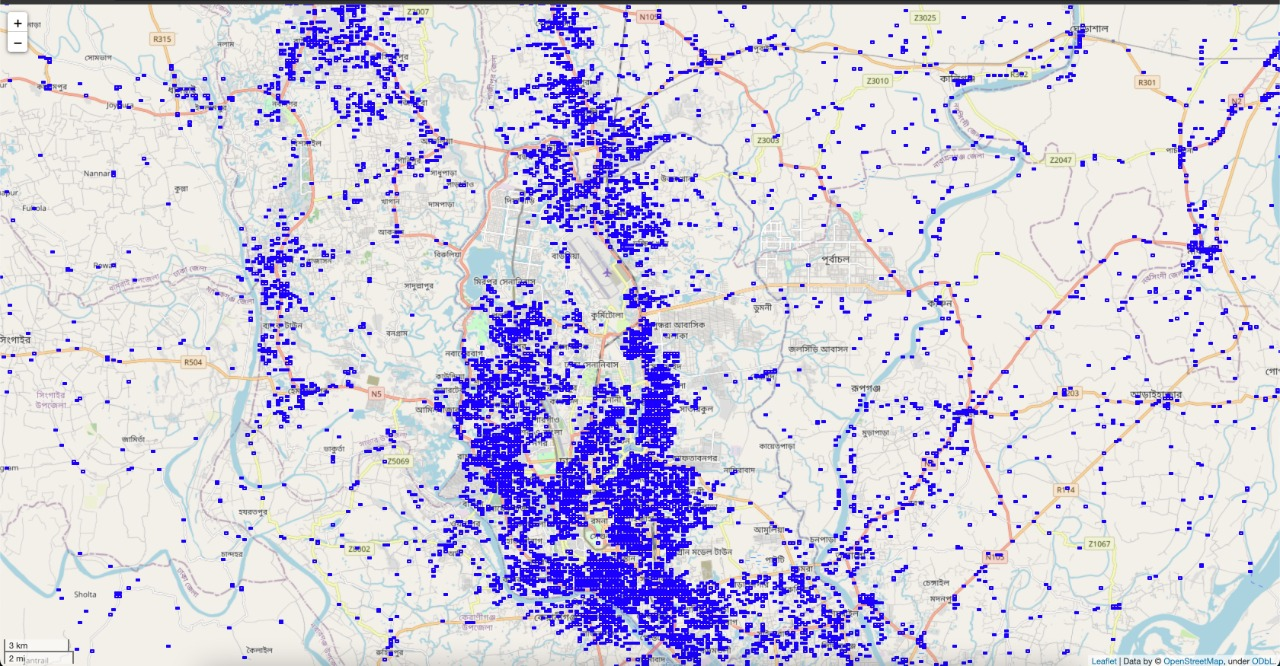

# Q4: For next 10 retailer deployments, which geo-blocks should be targeted? What other info will complement this decision? Add relevant external data to support your recommendation and use visuals.
---
Discussed in the presentation

# Q5. What is peak hour in terms of sales? Also find the same for the number of transactions.

In [21]:
mega_df['ts']=pd.to_datetime(mega_df['ts'])
mega_df['hour']=mega_df.ts.dt.hour
mega_df


agent  customer  product                  ts        lat        lon  \
0         40120   9831403      778 2022-04-21 17:53:11  23.656979  90.514419   
1         40120  18703069      778 2022-03-20 11:02:34  23.656979  90.514419   
2         40120   9453322      778 2022-03-06 10:10:42  23.656979  90.514419   
3         40120   3833137      778 2022-05-09 11:33:54  23.656979  90.514419   
4         40120    653933      778 2022-06-04 11:20:46  23.656979  90.514419   
...         ...       ...      ...                 ...        ...        ...   
88816864  73457  12250028       26 2022-04-20 16:10:01  23.755129  90.375137   
88816865  73457  14024837      137 2022-04-20 16:13:35  23.755129  90.375137   
88816866  73457  10347781      814 2022-01-18 11:09:43  23.755129  90.375137   
88816867  18879  17196540      402 2022-06-06 20:58:45  23.158399  89.511856   
88816868  18879  17196508      707 2022-06-06 19:08:20  23.158399  89.511856   

           price        dt  hour  
0           20.0  20220101    17  
1           20.0  20220101    11  
2           20.0  20220101    10  
3           20.0  20220101    11  
4           20.0  20220101    11  
...          ...       ...   ...  
88816864  1032.0  20220420    16  
88816865  1133.0  20220420    16  
88816866  1989.0  20220118    11  
88816867  1397.0  20220606    20  
88816868  1790.0  20220125    19  

[88816869 rows x 9 columns]

Text(0, 0.5, 'Sum of sales')

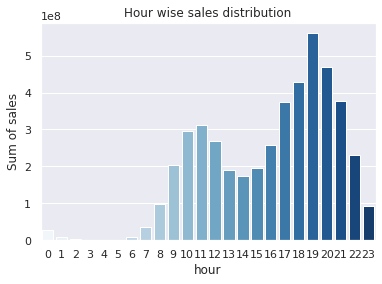

In [22]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
df_sales=pd.DataFrame(mega_df.groupby(mega_df['hour'])['price'].sum()).reset_index()
sns.barplot(x ='hour', y='price', data=df_sales,palette='Blues')
plt.title('Hour wise sales distribution')
plt.ylabel('Sum of sales')

Based on the time series bar chart we can see that there are two high period of sales and transactions over the day. The first high period is between 9 AM to 12:59 PM. The second high period is between 6PM and 8:59PM. But the whole days highest peak is between 7PM to 7:59PM during this time there is highest number of transactions, highest number of unique users and highest sales volume. So in termns of sales <b>7PM-7:59PM</b> or <b>19th hour</b> is the peak.

Text(0.5, 1.0, 'Hour wise transactions distribution')

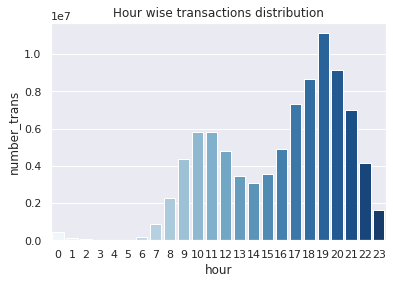

In [23]:
df_qty=pd.DataFrame(mega_df.groupby(mega_df['hour'])['hour'].count())
df_qty=df_qty.reset_index(drop=True)
df_qty['number_trans']=df_qty['hour'].copy()
df_qty['hour']= [x for x in range(24)]

sns.barplot(x ='hour', y='number_trans', data=df_qty,palette='Blues')
plt.title('Hour wise transactions distribution')

Based on the time series bar chart we can see that there are two high period of sales and transactions over the day. The first high period is between 9 AM to 12:59 PM. The second high period is between 6PM and 8:59PM. But the whole days highest peak is between 7PM to 7:59PM during this time there is highest number of transactions, highest number of unique users and highest sales volume. So in termns of number of transactions <b>7PM-7:59PM</b> or <b>19th hour</b> is the peak.

# Q6: What is the peak hour in summer and winter? Explain impact of seasonality. Use external data to support your explanation

Text(0, 0.5, 'Sum of sales')

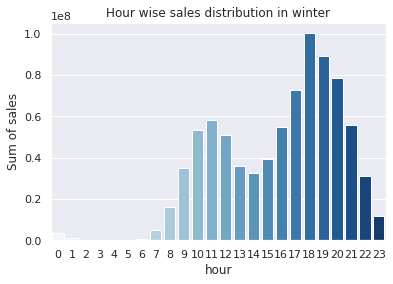

In [25]:
mega_df['month']=mega_df.ts.dt.month

df_winter=pd.DataFrame(mega_df.loc[mega_df.month <2].groupby(mega_df['hour'])['price'].sum()).reset_index()
sns.barplot(x ='hour', y='price', data=df_winter,palette='Blues')
plt.title('Hour wise sales distribution in winter')
plt.ylabel('Sum of sales')

Winter: We defined January and February as winter. We did similar plots as before and found out that the peak has shifted from the 19th hour to the 18th hour. So during the winter season, the peak for both sales and number of transactions is 6:00 PM to 6:59 PM.

Text(0, 0.5, 'Sum of sales')

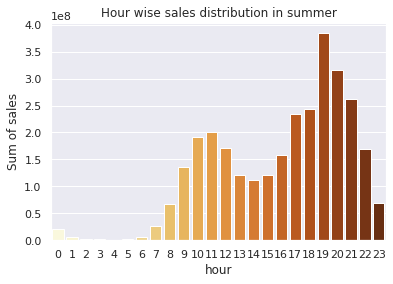

In [26]:
df_summer=pd.DataFrame(mega_df.loc[mega_df.month >2].groupby(mega_df['hour'])['price'].sum()).reset_index()
sns.barplot(x ='hour', y='price', data=df_summer,palette='YlOrBr')
plt.title('Hour wise sales distribution in summer')
plt.ylabel('Sum of sales')

Summer: Based on the hour-wise time series we can see that the peak hour is at the 19th hour or from 7:00PM to 7:59PM. We considered the months of March, April, May, June to be summer.

/tmp/ipykernel_5180/78985076.py:1: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  mega_df['week']=mega_df.ts.dt.week


Text(0, 0.5, 'Number of transactions')

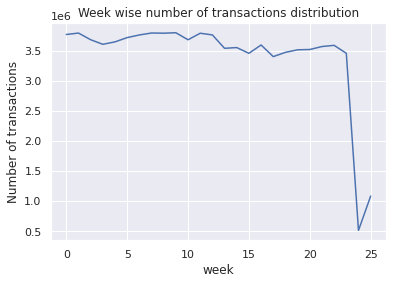

In [28]:
mega_df['week']=mega_df.ts.dt.week
df_week=pd.DataFrame(mega_df.groupby(mega_df['week'])['week'].count()).reset_index(drop=True)
df_week['number_trans']=df_week['week'].copy()
df_week['week']= [x for x in range(len(mega_df.week.unique()))]
sns.lineplot(x ='week', y='number_trans', data=df_week,palette='flare')
plt.title('Week wise number of transactions distribution')
plt.ylabel('Number of transactions')

Ramadan: During the month of Ramadan, we noticed a steep fall in sales and transaction volume during iftar hour 6:00 PM to 6:59 PM. Then it rapidly increased right after Iftar. This indicates that people were going out shopping during this time. So the peak hour during Ramadan is also 7:00PM to 7:59PM.

Seasonal Change Week on Week: During the second week of January we noticed a steep drop in the number of transactions. The number of covid cases was on the rise during this period, and there were some lockdown restrictions. Due to these restrictions, the number of transactions might have fallen. The week on week total transactions rose again during the month of February. And it stayed high until the month of April. The number of transactions fell at the start of Ramadan and stayed at the same level until June. This could indicate two things: people reduced their spendings during Eid and post Eid. Or due to inflation, which was very prevalent during Ramadan and post Eid, the spending power of general people reduced significantly. As a result the overall transaction numbers fell during Ramadan and didn’t rise back up again

# Q7: Create a sales forecast model for forecasting

### A: Next week’s daily total sales

In [29]:
import pandas as pd
import numpy as np
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from random import random
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, ExponentialSmoothing, Holt
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from pmdarima import model_selection

from pmdarima.arima import auto_arima
from pmdarima import pipeline
from pmdarima import model_selection
from pmdarima import preprocessing as ppc
from pmdarima import arima

import matplotlib.pyplot as plt

import warnings
warnings.simplefilter(action='ignore', category= FutureWarning)

plt.rcParams.update({'figure.figsize': (25, 12)})

In [30]:
df = pd.read_csv('./encoded_data/query_results/dod_sales.csv')
# df = df[['date', 'total_sales']]
df['date'] = pd.to_datetime(df['date'])
df

date       sales
0   2022-01-01  27141316.0
1   2022-01-02  27286457.0
2   2022-01-03  27405925.0
3   2022-01-04  27959309.0
4   2022-01-05  26429408.0
..         ...         ...
166 2022-06-16  27401373.0
167 2022-06-17  22378222.0
168 2022-06-18  26338910.0
169 2022-06-19  25963066.0
170 2022-06-20  26905096.0

[171 rows x 2 columns]

<AxesSubplot:xlabel='date'>

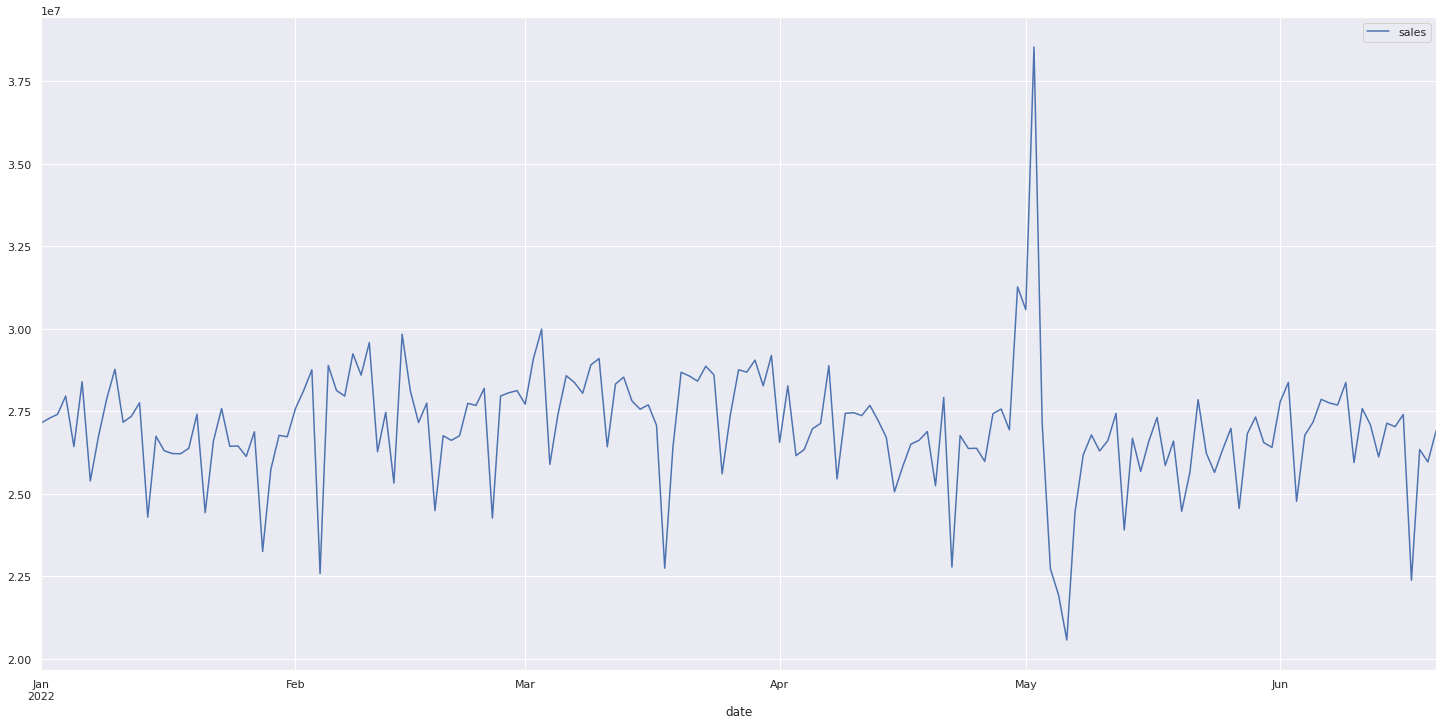

In [31]:
df.set_index('date').plot()

# Decomposition

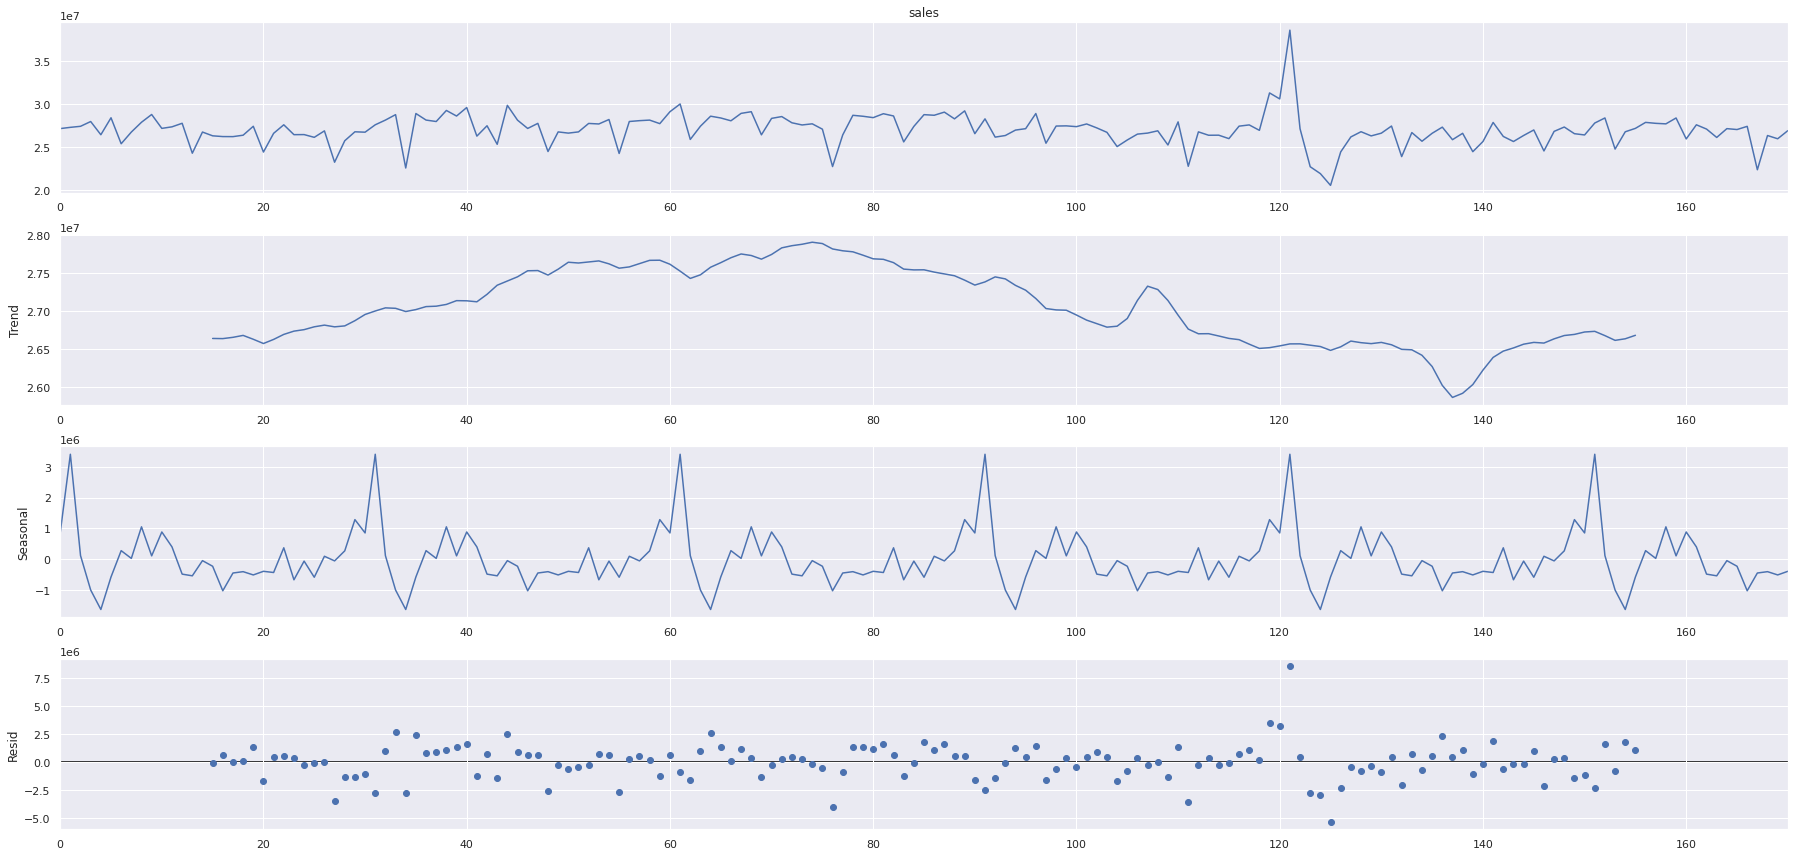

In [32]:
decomposition = sm.tsa.seasonal_decompose(df["sales"], period=30, model='additive') 
figure = decomposition.plot()
plt.show()

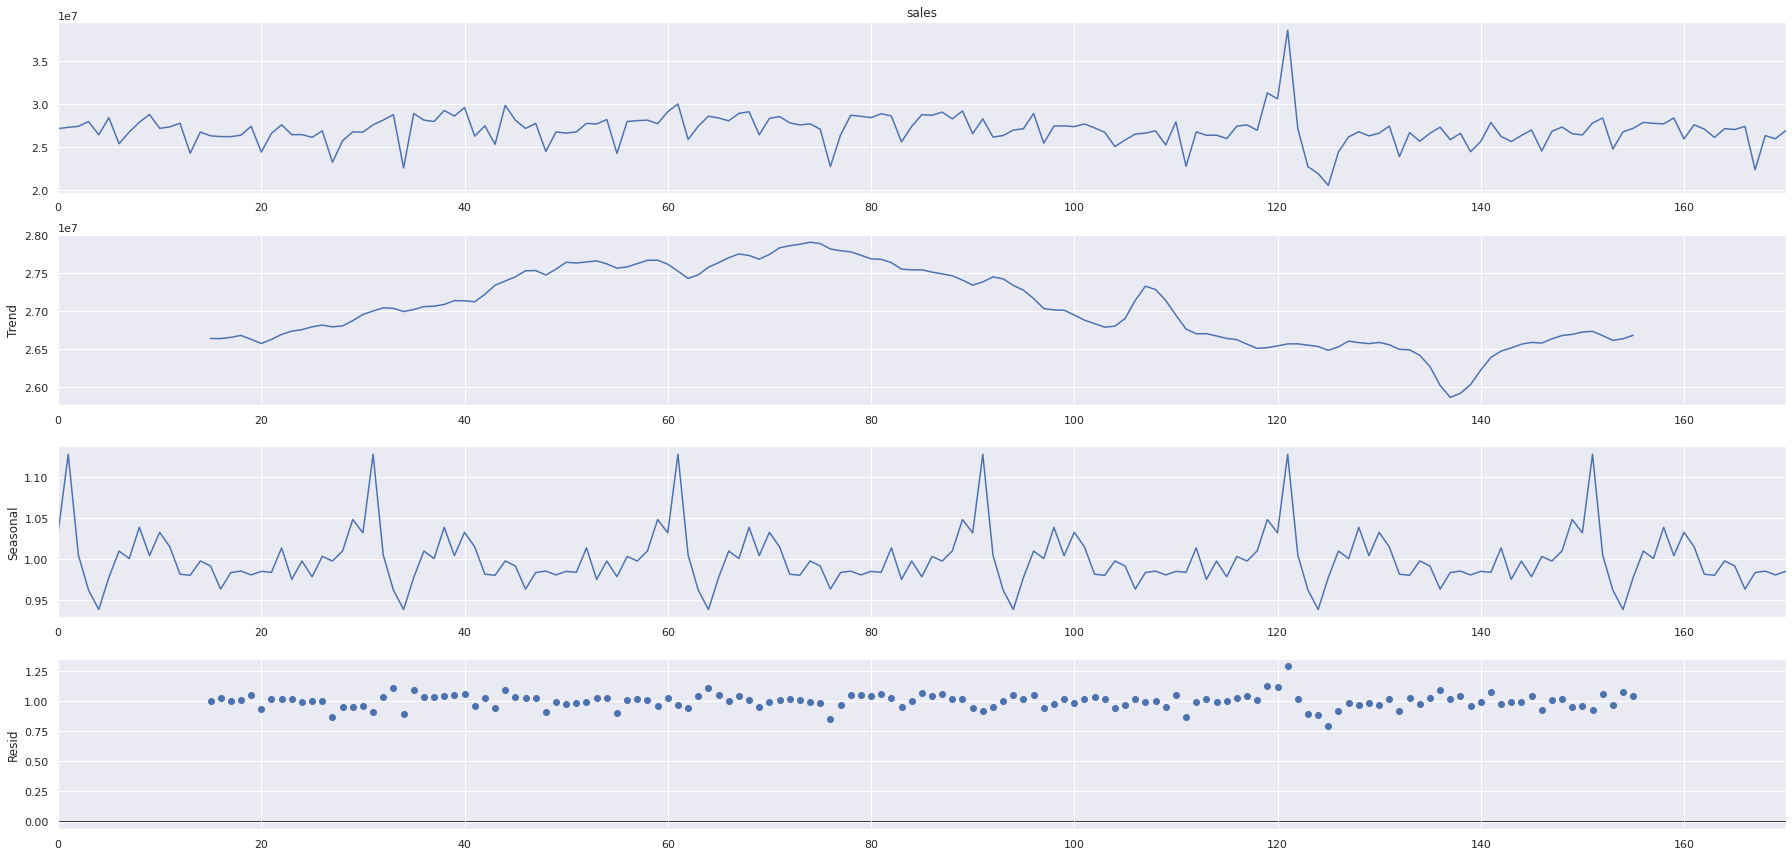

In [33]:
decomposition = sm.tsa.seasonal_decompose(df["sales"], period=30, model='multiplicative') 
figure = decomposition.plot()
plt.show()

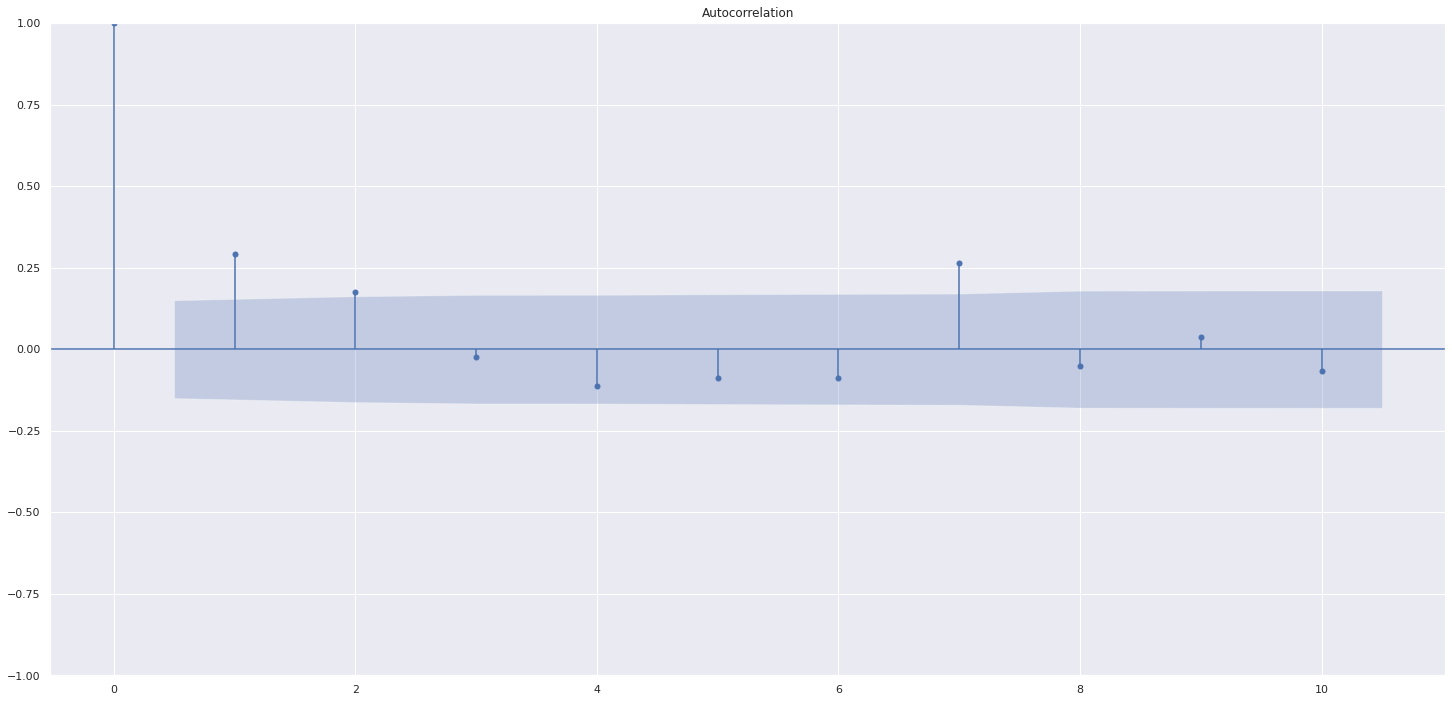

In [34]:
plot_acf(df['sales'], lags=10)
print()

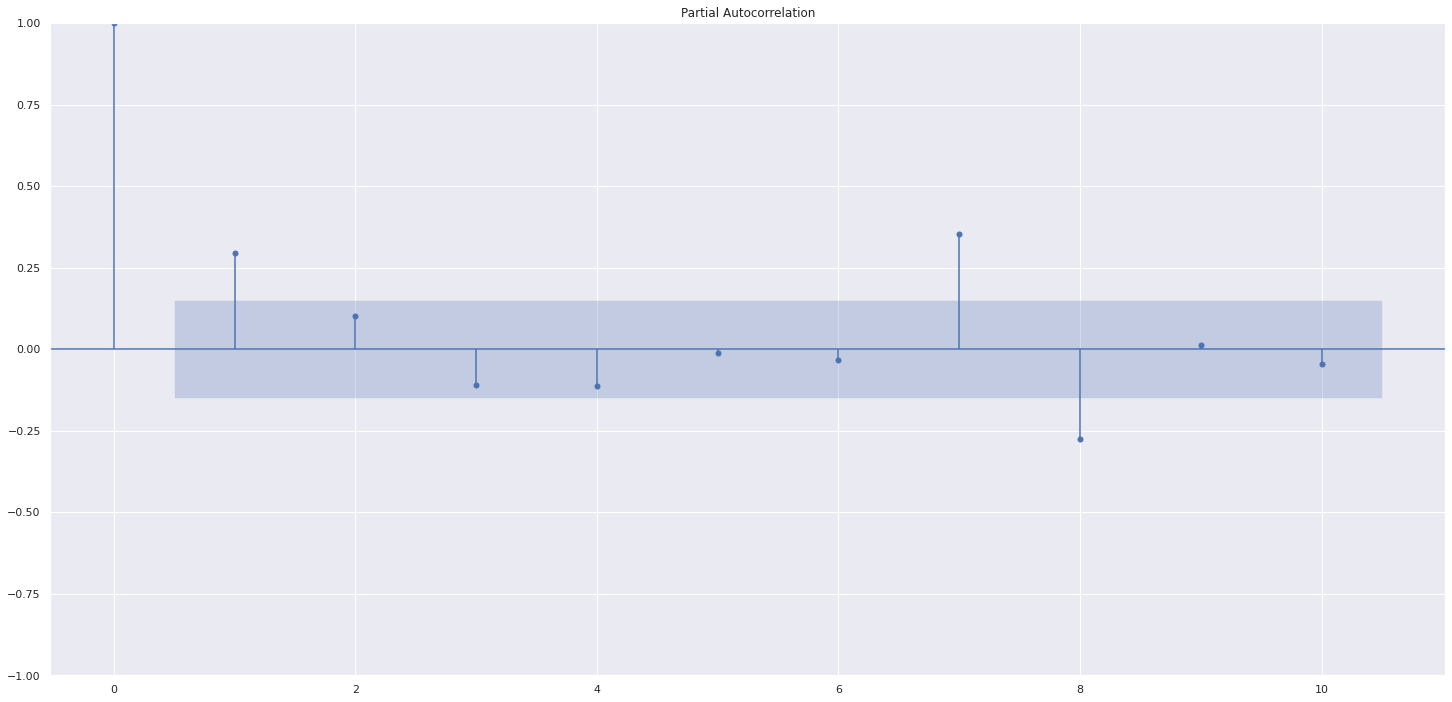

In [35]:
plot_pacf(df['sales'], lags=10)
print()

In [36]:
result = adfuller(df['sales'])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))
    pass

ADF Statistic: -2.928209
p-value: 0.042165
Critical Values:
	1%: -3.473
	5%: -2.880
	10%: -2.577


In [37]:
xtrain, xvalid = model_selection.train_test_split(df['sales'], test_size = 15)

In [38]:
model_autoARIMA = auto_arima(xtrain, start_p=7, start_q=7 ,
                      test='adf',       
                      max_p= 7, max_q=7, 
                      m= 7,              
                      d= 1,
                      seasonal=True,   
                      start_P=1, 
                      D=1, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(6,1,6)(1,1,1)[7]             : AIC=4718.787, Time=1.36 sec
 ARIMA(0,1,0)(0,1,0)[7]             : AIC=4755.613, Time=0.01 sec
 ARIMA(1,1,0)(1,1,0)[7]             : AIC=4729.189, Time=0.03 sec
 ARIMA(0,1,1)(0,1,1)[7]             : AIC=4709.716, Time=0.04 sec
 ARIMA(0,1,1)(0,1,0)[7]             : AIC=4749.632, Time=0.01 sec
 ARIMA(0,1,1)(1,1,1)[7]             : AIC=4705.612, Time=0.08 sec
 ARIMA(0,1,1)(1,1,0)[7]             : AIC=4728.937, Time=0.04 sec
 ARIMA(0,1,1)(2,1,1)[7]             : AIC=4707.262, Time=0.18 sec
 ARIMA(0,1,1)(1,1,2)[7]             : AIC=4707.314, Time=0.21 sec
 ARIMA(0,1,1)(0,1,2)[7]             : AIC=4705.339, Time=0.11 sec
 ARIMA(0,1,0)(0,1,2)[7]             : AIC=4703.139, Time=0.10 sec
 ARIMA(0,1,0)(0,1,1)[7]             : AIC=4706.717, Time=0.02 sec
 ARIMA(0,1,0)(1,1,2)[7]             : AIC=4698.256, Time=0.17 sec
 ARIMA(0,1,0)(1,1,1)[7]             : AIC=4699.994, Time=0.05 sec
 ARIMA(0,1,0)(2,1,2)[7]          

In [39]:
print(model_autoARIMA.summary())

                                       SARIMAX Results                                        
Dep. Variable:                                      y   No. Observations:                  156
Model:             SARIMAX(0, 1, 0)x(2, 1, [1, 2], 7)   Log Likelihood               -2344.005
Date:                                Sat, 25 Jun 2022   AIC                           4698.009
Time:                                        06:18:04   BIC                           4712.995
Sample:                                             0   HQIC                          4704.098
                                                - 156                                         
Covariance Type:                                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L7       -0.6839      0.166     -4.114      0.000      -1.010      -0.358
ar.

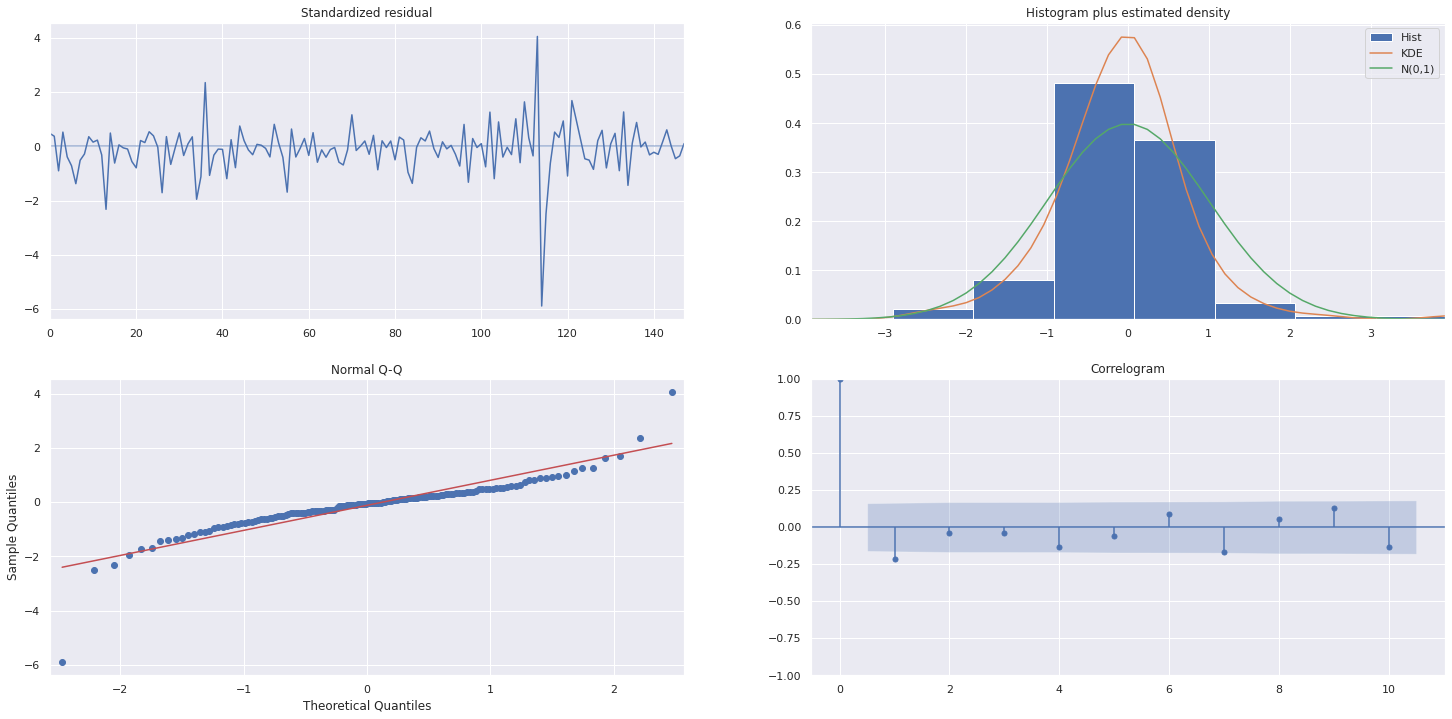

In [40]:
model_autoARIMA.plot_diagnostics()
plt.show()

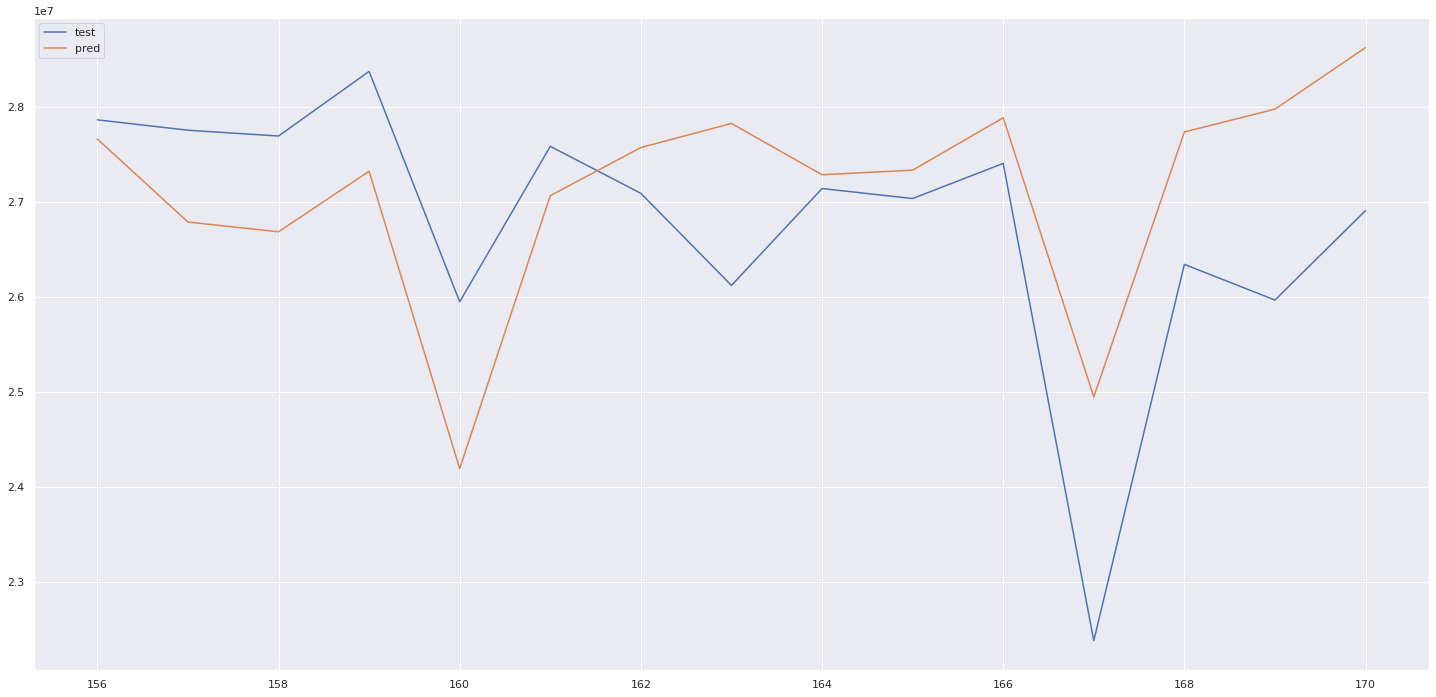

In [41]:
pred = model_autoARIMA.predict(xvalid.shape[0])

pd.DataFrame({'test':xvalid,'pred':pred}).plot();plt.show()

### B: Next day’s sales of each retail

In [42]:
import pandas as pd
import numpy as np

from sklearn.metrics import mean_squared_error, mean_absolute_error
from xgboost import XGBRegressor
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
import math

import seaborn as sns
import matplotlib.pyplot as plt

PARENT_SEED = 1400

Initially, we used rolling average of the previous 5 weekdays sales values to establish a baseline of the model's accuracy. We got an MAE of ~230.

Then we tried to breakdown the problem & solved it differently by introduxing new features.

This is essentially a time series problem. We have to predict next day's sales for each of the retail.

An approach to do this is fitting an individual model for each of the retails, because each retailer will have different patterns based on serveral things like location, density, distinct products & so on, so one single time series model will not be able to generalize. 

Hence, we thought of attacking the problem by looking at the data in a tabular data. We will have multiple features here:

1. dayofweek - for which day of the week we are predicting the sales for. This is the representation of time. 

2. neighbors - how many retail points this agent has around him within 500m radius. This tells about the density of the area the agent is in.

3. distinct products - How many distinct products/services the retailer has on that particular day.

4. distinction ratio - This is a ratio of no of distinct products & no of total products present to that agent on that particular day. this features tells about the availability of the products the agent has to offer.

5. distinct product value - 

6. previous 5 weekdays sales value - the historical sales data for that particular weekdays in the previous 5 weeks for time series components. E.g., for predicting this Tuesday's sales for a retailer we consider previous 5 Tuesday's data.

7. administration level 2 location (District) - We have also incorporated the districts for each of the agent because which district the agent is in do affect the agent's sales.

## The SQL code that creates the training_data

In [ ]:
df = pd.read_csv('./encoded_data/query_results/training_data_2.csv')
# df.drop(columns=['adm1_name'], axis=0, inplace=True)
# df.drop(columns=['adm3_name'], axis=0, inplace=True)
# df.drop(columns=['product_dis'], axis=0, inplace=True)
df

In [ ]:
def encoder_ohe(df, cols):
    df = df.copy(deep=True)
    
    for col in cols:
        encoder = OneHotEncoder(categories="auto", dtype=int)
        original_cols = list(df.columns)
        encoded_vals = encoder.fit_transform(df[[col]]).toarray().T
        encoded_cols = list(encoder.get_feature_names_out())
        index = original_cols.index(col)
        new_cols = original_cols[:index] + encoded_cols + original_cols[index+1:]
        for iterator, encoded_col in enumerate(encoded_cols):
            df[encoded_col] = encoded_vals[iterator]
            pass
        df = df[new_cols]
        pass
    return df

df = encoder_ohe(df, ['dayofweek'])
df = encoder_ohe(df, ['adm2_name'])

df

In [ ]:
feature_cols = [col for col in df.columns if col not in ['agent', 'date', 'total_sales']]
print(feature_cols)

label_col = ['total_sales']

X = df[feature_cols].values
Y = df[label_col].values
print(X.shape, Y.shape)

In [ ]:
x_train, x_val, y_train, y_val = train_test_split(X, Y, test_size=0.30, random_state=1400)
print(x_train.shape, x_val.shape, y_train.shape, y_val.shape)

In [ ]:
%%time
xgb = XGBRegressor(learning_rate=0.01, n_estimators=1000,
                               max_depth=5, min_child_weight=0,
                               gamma=0, subsample=0.7,
                               colsample_bytree=0.7, nthread=-1,
                               reg_alpha=0.00006, random_state=PARENT_SEED)
#                     objective = 'reg:pseudohubererror')

xgb.fit(x_train, y_train)

In [ ]:
%%time
y_pred = xgb.predict(x_val)
print('Mean Absolute Error: ', mean_absolute_error(y_pred, y_val))

print('RMSE Score: ', math.sqrt(mean_squared_error(y_pred, y_val)))

# Q8: From the data, can you find which areas are

- Residential
- Tourist spots
- Transit hubs
- Corporate area

Explain your logics for this categorization. Use visuals to support your logic.

### The query to generate the viz

Refer to Dhaka.html in the supplementary files' link at the end of the presentation file

# Q9. Find out the customers who are travelling most? Only list Top 20.

To answer this question, we first needed to define our definition of ‘most traveled’ customer. We settled on the following combination:

- Average Distance traveled per transaction: This was important to filter out customers who transacted a lot but only within a short distance, that is, in nearby localities.
- Unique Agents Transacted: This metric was chosen because the higher the number, the more likely that the person traveled greater distances. This was also important to filter out those people who only travel to 2 different (but greatly apart) locations (could be business travelers/etc.) because we felt that it does not truly represent ‘the most traveled customer’.
- Number of transactions: We found this metric to be useful to identify those people who are repeating travelers to only certain locations.
- Agent uniqueness: A ratio of B over C, it simplifies the search space of the problem.

In [ ]:
%%time
drop_indices = list(mega_df[(mega_df['lat']<20.34) | (mega_df['lat']>26.38) | (mega_df['lon']<88.01) | (mega_df['lon']>92.41)].index)
mega_df = mega_df.drop(drop_indices, axis=0).reset_index(drop=True)
del drop_indices
mega_df

## Average distance travelled per user

In [ ]:
%%time

mega_df.sort_values(by=['customer', 'ts'], ascending=True, inplace=True)
mega_df.reset_index(drop=True)

mega_df['prev_lat'] = mega_df.groupby('customer')['lat'].shift(1)
mega_df['prev_lon'] = mega_df.groupby('customer')['lon'].shift(1)

mega_df['distance'] = [haversine(lat, lon, prev_lat, prev_lon)/1000 for lat,lon,prev_lat,prev_lon in zip(mega_df['lat'], mega_df['lon'], mega_df['prev_lat'], mega_df['prev_lon'])]

mega_df.drop(columns=['prev_lat', 'prev_lon'], axis=0, inplace=True)

distances = mega_df.groupby(['customer'])['distance'].mean().to_frame().reset_index()
distances

In [ ]:
mean_distance = list(distances['distance'])

plt.figure(figsize=(100,7))
print(f"\
      25% {np.nanpercentile(mean_distance, 25)} KM,\n\
      50% {np.nanpercentile(mean_distance, 50)} KM,\n\
      75% {np.nanpercentile(mean_distance, 75)} KM,\n\
      90% {np.nanpercentile(mean_distance, 90)} KM,\n\
      95% {np.nanpercentile(mean_distance, 95)} KM,\n\
      MAX: {np.nanmax(mean_distance)} KM\
      ")

sns.boxplot(list(mean_distance))
plt.show()

## Distinct agent count

In [ ]:
unique_agents = mega_df.groupby(['customer'])['agent'].nunique().sort_values(ascending=False).to_frame().reset_index()
unique_agents

In [ ]:
mean_unique_agent = list(unique_agents['agent'])

plt.figure(figsize=(100,7))
print(f"\
      25% {np.nanpercentile(mean_unique_agent, 25)},\n\
      50% {np.nanpercentile(mean_unique_agent, 50)},\n\
      75% {np.nanpercentile(mean_unique_agent, 75)},\n\
      90% {np.nanpercentile(mean_unique_agent, 90)},\n\
      95% {np.nanpercentile(mean_unique_agent, 95)},\n\
      MAX: {np.nanmax(mean_unique_agent)}\
      ")

sns.boxplot(list(mean_unique_agent))
plt.show()

## Number of transactions

In [ ]:
transactions = mega_df.groupby(['customer'])['agent'].count().sort_values(ascending=False).to_frame().reset_index()
transactions.rename(columns = {'agent':'transaction'}, inplace=True)
transactions

In [ ]:
mean_transaction = list(transactions['transaction'])

plt.figure(figsize=(100,7))
print(f"\
      25% {np.nanpercentile(mean_transaction, 25)},\n\
      50% {np.nanpercentile(mean_transaction, 50)},\n\
      75% {np.nanpercentile(mean_transaction, 75)},\n\
      90% {np.nanpercentile(mean_transaction, 90)},\n\
      95% {np.nanpercentile(mean_transaction, 95)},\n\
      MAX: {np.nanmax(mean_transaction)}\
      ")

sns.boxplot(list(mean_transaction))
plt.show()

## Merging all the metrics to create a customer profile 

In [ ]:
%%time
customers = distances.merge(unique_agents, on=['customer'], how='inner').reset_index(drop=True)
customers = customers.merge(transactions, on=['customer'], how='inner').reset_index(drop=True)

## Filtering users based on the 95th percentile values of each of the metrics

In [ ]:
customers = customers[(customers['distance']>93) & (customers['agent']>5) & (customers['transaction']>18)].reset_index(drop=True)
customers['agent_to_trx_ratio'] = [agent/transaction for agent, transaction in zip(customers['agent'], customers['transaction'])]
customers

In [ ]:
customers.sort_values(by=['agent_to_trx_ratio', 'distance',  'agent', 'transaction'], ascending=False, inplace=True)
customers

## Choosing the number 1 customer - Customer_8212684 to be the top traveller

In [ ]:
mega_df[mega_df['customer']==16803577]

customer_id_decoder_map[16803577]

In [ ]:
travellers = list(customers['customer'])
mega_df = mega_df[mega_df['customer'].isin(travellers)].reset_index(drop=True)
mega_df

agents1 = mega_df[['agent', 'lat', 'lon']].drop_duplicates(keep="first").reset_index(drop=True)

agents2 = mega_df.groupby(['agent']).agg(
                                customer=('customer', pd.Series.nunique),
                                txn=('product', 'count'),
                                price=('price', 'sum')
            ).sort_values(by=['customer', 'txn', 'price'], ascending=False).reset_index()

travelling_agents = agents1.merge(agents2, on=['agent'], how='inner').reset_index(drop=True)
travelling_agents.to_csv('travelling_agents.csv', index=False)

# Q10: Find out retails serving highest number of travelers? What other business ideas can be implemented to maximize sales from these points?

Around 13k unique agents transacted with customers we identified as top travelers. However only around 200 agents carried out 15 or more transactions with them. Many of these agents were situated along major highways approaching Dhaka and Chattogram. This gives us a hint that these travelers may transact on a stop over or on break. They could also be professional drivers.

To attract these travelers, we can design a special bundle package for mobile operators. This would include voice and data and can only be availed via these retailers.

For the viz file refer to the agent_top_traveler.html in the supplementary link at the end of the presentation.

# Q11. For your next big billboard placement, which location will be best and which one product will feature in that billboard?

We have identified which products are the most sold products over the course of 6 months. We decided to take the top 5 products and plot their distribution across the map of Bangladesh where product 16 and 17 were ranked first and second respectively.

- Product 16: We have noticed that product 16 has a very high density in dhaka and chittagong this implies this is a product which is highly used in developed cities. As this an mfs company we have two assumptions

    - Assumption 1: product 16 is either any kind of cash injection method because there are a high number of working people who are willing to send money outside of Dhaka and Chittagong

    - Assumption 2: product 16 is a payment feature and since its developed city people tend to use this feature for digital payments such as payments for buying products online, paying restaurants bills etc.


- Product 17 : We have also noticed product 17 has more spread out distribution across the entire country. Especially its dense towards rajshahi division and khulna division.

Our first assumption is that 17 is a cash out product because it’s distributed across the country. And since this is an MFS, the cash out feature will be one of the most used products. Digital payment is more prevalent in developed cities so this product will not be used as much in Dhaka and Chittagong. But in rural areas, where most transactions are done using cash, the cash out feature will be used more. We can see from the geographic distribution, product 17 is used more outside Dhaka and Chittagong. 

**Billboard Location**: 

We know our most popular product is product 16 which according to our hypothesis might be a cash injection or digital payment feature. This should be the product we put on the billboard in an upcoming emerging market such as khulna. As khulna has the third highest economy in major cities it has the potential to become more Dhaka and Chittagong like, if we would be more specific with the location we can use it in places in khulna where there are high collar workers such as garment workers who will send money as outflow. This product has a low price of 20 taka which makes it a low entry barrier. It can thus help the new market adopt our product as a result leading to market expansion for the mfs company.

Visualization is discussed further in the presentation.